In [5]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

In [6]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [7]:
from sqlalchemy import create_engine
import logging
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, String
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

In [8]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Data Preprocessing

Running this part will download all the files in the local repo, but it will take a long time. 
Depending on the machine it runs on, it might throw error due to large size.

### Clean Weather Data

All weather csv are cleaned and seperated into hours part and days part

In [11]:
#create the clean version of weather csv and seprated into two parts
def create_weather_csv(filename):
    # make sure the output title is consistent 
    title1 = ""
    title2 = ""
    m = re.search(r'(\d+_weather)', filename)
    if m:
        title1 = m.group(1) + '_hours.csv'
        title2 = m.group(1) + '_days.csv'
    
    
    #this function cleans the weather csv and output 2 csv, one is for daily and one is for hour
    df = pd.read_csv(filename,usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])
    #deal with missing value and special character
    df = df.fillna(0)
    df = df.replace('T',0)
    df = df.replace('s','',regex = True)
    #change the data type
    df.DATE = pd.to_datetime(df.DATE)
    df = df.astype({'HourlyPrecipitation':float,'HourlyWindSpeed':float})
    df.set_index('DATE',drop = True).to_csv(title1)
    df = df.resample('D', on='DATE').mean() 
    df = df.rename(mapper = {"HourlyPrecipitation":"DailyPrecipitation", "HourlyWindSpeed":"DailyWindSpeed"},axis = 1)
    df.to_csv(title2)
    
    

In [10]:
for i in range(2009,2016):
    #create all weather data from 2009 to 2015
    filename = str(i)+"_weather.csv"
    create_weather_csv(filename)

FileNotFoundError: [Errno 2] File 2009_weather.csv does not exist: '2009_weather.csv'

### Clean Uber Data

Clean uber sample data and makes the name consistent to the yellow taxi data

In [12]:
uber = pd.read_csv('uber_rides_sample.csv')

In [13]:
#this function gets the distance between two coordinates
def get_distance(lon1,lat1,lon2,lat2):
    from math import sin, cos, sqrt, atan2, radians
    R = 6373
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    lon2 = radians(lon2)
    lat2 = radians(lat2)
    
    dlon = lon1 - lon2
    dlat = lat1 - lat2
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance

In [14]:
#add distance to the dataframe with coordinates
def add_distance(df):
    distance = []
    lon1 = list(df['pickup_longitude'])
    lon2 = list(df['dropoff_longitude'])
    lat1 = list(df['pickup_latitude'])
    lat2 = list(df['dropoff_latitude'])
    for i in range(len(lon1)):
        distance.append(get_distance(lon1[i],lat1[i],lon2[i],lat2[i]))
    df['distance']  = distance

In [15]:
get_distance(1,2,3,4)

314.3819156466156

In [16]:
#create the clean version of uber dataframe
def create_uber(df):
    #clean uber data
    df = df.rename(columns = lambda x: x.strip())
   
    #drop and rename column
    to_drop = [
        "Unnamed: 0",
        "key",
        "passenger_count"
    ]
    
    mapper = {
        "pickup_datetime" :"pickup_time",
        "fare_amount" : "charge"
    }
    df = df.drop(to_drop, axis = 1,errors = "ignore")
    df = df.rename(mapper, axis = 1)
    df.dropna(inplace = True)
    
    #modify datatype
    df = df.astype({"pickup_time":np.datetime64})
    
    
    
    #add distance
    add_distance(df)
    df.to_csv('uber.csv',index = False)

In [17]:
create_uber(uber)

### Clean Yellow Taxi Data

find all csv files and filter them, then download as a dataframe and clean the data

In [18]:
def get_csv_links():
    #this function visits： https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
    #It requests the source code on the website and get all the hrefs related to csv
    #the urls are saved in link_lists
    link_lists = []
    url = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    aclasses = soup.find_all('a')
    for a in aclasses:
        link_lists.append(a.get('href'))
    #Then we filter on link_lists using re because we only want to grab csv for yellow taxi ranging from 2009 - 2015.
    csv_links = []
    pattern = re.compile(r'.yellow_tripdata_(200[9]|201[0-5])-\d\d\.csv$')
    for i in link_lists:
        if re.search(pattern,i):
            csv_links.append(i)
    return csv_links
    

In [48]:
westlimit=-74.242330; southlimit=40.560445; eastlimit=-73.717047; northlimit=40.908524
#Remove the data that is not within the limits specified above

def fix_longitude(input_longitude):
    try:
        input_longitude = float(input_longitude)
    except:
        return np.NaN
    if input_longitude < westlimit or input_longitude > eastlimit:
        return np.NaN
    return input_longitude


def fix_latitude(input_latitude):
    try:
        input_latitude = float(input_latitude)
    except:
        return np.NaN
    if input_latitude < southlimit or input_latitude > northlimit:
        return np.NaN
    return input_latitude


def fix_df(df):
    df['pickup_longitude']=df['pickup_longitude'].apply(fix_longitude)
    df['dropoff_longitude']=df['dropoff_longitude'].apply(fix_longitude)
    df['pickup_latitude']=df['pickup_latitude'].apply(fix_latitude)
    df['dropoff_latitude']=df['dropoff_latitude'].apply(fix_latitude)
    df.dropna(inplace = True)
    return df 

In [21]:
def create_csv(csv_link):
   
    # make sure the output title is consistent 
    title = ""
    m = re.search(r'(yellow.+)', csv_link)
    if m:
        title = m.group(1)
   
    #read the data into a dataframe
    df = pd.read_csv(csv_link,on_bad_lines='skip')
    df = df.rename(columns = lambda x: x.strip())
   
    #drop and rename column
    to_drop = [
        "Unnamed: 0",
        "vendor_name",
        "vendor_id",
        "Vendor_id",
        'VendorID',
        "Trip_distance",
        "Trip_Distance",
        "trip_distance",
        "Rate_Code",
        "store_and_forward",
        "store_and_fwd_flag",
        "Payment_Type",
        "Fare_Amt",
        "surcharge",
        "mta_tax",
        "Tolls_Amt",
        "rate_code",
        "RatecodeID",
        "RateCodeID",
        "payment_type",
        "fare_amount",
        "extra",
        "tolls_amount",
        "improvement_surcharge",
        "Passenger_Count",
        "passenger_count"
    ]
    
    mapper = {
        "Trip_Pickup_DateTime" : "pickup_time",
        "tpep_pickup_datetime" : "pickup_time",
        "pickup_datetime": "pickup_time",
        "dropoff_datetime" : "dropoff_time",
        "Trip_Dropoff_DateTime" : "dropoff_time",
        "tpep_dropoff_datetime" : "dropoff_time",
        "Start_Lon" : "pickup_longitude",
        "Start_Lat" : "pickup_latitude",
        "End_Lon" : "dropoff_longitude",
        "End_Lat" : "dropoff_latitude",
        "Tip_Amt" : 'tip',
        "tip_amount" : "tip",
        "Total_Amt" : "charge",
        "total_amount" : "charge"
    }
    df = df.drop(to_drop, axis = 1,errors = "ignore")
    df = df.rename(mapper, axis = 1)
    df.dropna(inplace = True)
    
    #modify datatype
    df = df.astype({"pickup_time":np.datetime64,"dropoff_time": np.datetime64})
    
    
    #make sure the trip is within(40.560445, -74.242330) and (40.908524, -73.717047)
    fix_df(df)
    
    #sample 3000 rows
    df = df.sample(n=3000)
    
    #add distance
    add_distance(df)
    df.reset_index(inplace = True, drop = True)
    
    df.to_csv(title,index= False)

run this to download all the yellow taxi sample data

In [ ]:
from tqdm import tqdm
links = get_csv_links()
for i in tqdm(range(len(links))):
    create_csv(links[i])


# Storing Data

We first read all csv files into 4 dataframe

In [53]:
def createuber():
    #this function reads in uber.csv and returns the data in pd.DataFrame format
    uber = pd.read_csv('uber.csv')
    uber.pickup_time = pd.to_datetime(uber.pickup_time)
    uber = uber[uber.distance != 0]
    fix_df(uber)
    return uber

In [26]:
def createtaxi():
    #this function reads in yellow_trip_{year}-{month}.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        for j in range(1,13):
            if j <10:
                filename = f'yellow_tripdata_{i}-0{j}.csv'
                filenames.append(filename)
            else:
                filename = f'yellow_tripdata_{i}-{j}.csv'
                filenames.append(filename)
    taxi = pd.read_csv('yellow_tripdata_2009-01.csv',usecols = ['pickup_time','dropoff_time','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','charge','tip','distance'],nrows = 2314)
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i],usecols = ['pickup_time','dropoff_time','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','charge','tip','distance'], nrows = 2314)
        taxi = pd.concat([taxi,df])
    taxi.reset_index(inplace = True, drop = True)
    taxi.pickup_time = pd.to_datetime(taxi.pickup_time)
    taxi.dropoff_time = pd.to_datetime(taxi.dropoff_time)
    return taxi

In [27]:
def createhourlyweather():
    #this function reads in {year}_weather_hours.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        filenames.append(f'{i}_weather_hours.csv')
    weather_hourly = pd.read_csv('2009_weather_hours.csv')
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i])
        weather_hourly = pd.concat([weather_hourly,df])
    weather_hourly.reset_index(inplace = True, drop = True)
    weather_hourly.DATE = pd.to_datetime(weather_hourly.DATE)
    weather_hourly['DATE'] = weather_hourly['DATE'].dt.floor('H')
    weather_hourly = weather_hourly.drop_duplicates('DATE',keep = 'first')
    mapper = {'DATE': 'date', "HourlyPrecipitation":'precipitation','HourlyWindSpeed':'windspeed'}
    weather_hourly = weather_hourly.rename(mapper,axis = 1)
    return weather_hourly
    

In [28]:
def createdailyweather():
    #this function reads in {year}_weather_days.csv and returns the data in pd.DataFrame format
    filenames = []
    for i in range(2009,2016):
        filenames.append(f'{i}_weather_days.csv')
    weather_daily = pd.read_csv('2009_weather_days.csv')
    for i in range(1,len(filenames)):
        df = pd.read_csv(filenames[i])
        weather_daily = pd.concat([weather_daily,df])
    weather_daily.reset_index(inplace = True, drop = True)
    weather_daily.DATE = pd.to_datetime(weather_daily.DATE)
    mapper = {'DATE': 'date', "DailyPrecipitation":'precipitation','DailyWindSpeed':'windspeed'}
    weather_daily = weather_daily.rename(mapper,axis = 1)
    return weather_daily

In [54]:
uber = createuber()
taxi = createtaxi()
weather_hourly= createhourlyweather()
weather_daily = createdailyweather()

Now we try to build database and four tables

In [56]:
#build database
engine = create_engine(f"sqlite:///ubertaxi.db", echo=True)
sqllogger = logging.getLogger("sqlalchemy.engine.Engine")
formatter = logging.Formatter("[sqlalchemy] %(message)s")
sqllogger.handlers[0].setFormatter(formatter)
Base = declarative_base()
Base.metadata.create_all(engine, checkfirst=True)
# sessionmaker returns a Session class
Session = sessionmaker(bind=engine)
# and we create an instance of Session
session = Session()

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] COMMIT


In [57]:
def readsqlfile(filename):
    #I am gonna be honest, I found this on stack overflow. Basically it allows the sqlalchemy to execute multiple queries 
    #in one file. 
    sql_file = open(filename,'r')

    # Create an empty command string
    sql_command = ''
    for line in sql_file:
        # Ignore commented lines
        if not line.startswith('--') and line.strip('\n'):
            # Append line to the command string
            sql_command += line.strip('\n')
            # If the command string ends with ';', it is a full statement
            if sql_command.endswith(';'):
                # Try to execute statement and commit it
                try:
                    session.execute(text(sql_command))
                    session.commit()
                # Assert in case of error
                except:
                    print('Ops')
                # Finally, clear command string
                finally:
                    sql_command = ''

Read schema file

In [58]:
readsqlfile('schema.sql')

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] CREATE TABLE weather_daily(date Datetime,precipitation FLOAT,windspeed FLOAT);
[sqlalchemy] [generated in 0.00116s] ()
Ops
[sqlalchemy] CREATE TABLE weather_hourly(date Datetime,precipitation FLOAT,windspeed FLOAT);
[sqlalchemy] [generated in 0.00112s] ()
Ops
[sqlalchemy] CREATE TABLE yellow_taxi(pickup_time DATETIME,dropoff_time DATETIME,pickup_longitude FLOAT,pickup_latitude FLOAT,dropoff_longitude FLOAT,dropoff_latitude FLOAT,tip FLOAT,charge FLOAT,distance FLOAT);
[sqlalchemy] [generated in 0.00142s] ()
Ops
[sqlalchemy] CREATE TABLE Uber(charge FLOAT,pickup_time DATETIME,pickup_longitude FLOAT,dropoff_longitude FLOAT,pickup_latitude FLOAT,dropoff_latitude FLOAT,distance FLOAT);
[sqlalchemy] [generated in 0.00124s] ()
Ops


In [61]:
#add four dataframes into sql tables
#DONT EXECUTE TWINCE!!!!!
'''
uber.to_sql('Uber', engine, if_exists='replace',index = False)
taxi.to_sql('yellow_taxi', engine, if_exists='append',index = False)
weather_hourly.to_sql('weather_hourly', engine, if_exists='append',index = False)
weather_daily.to_sql('weather_daily', engine, if_exists='append',index = False)
'''

[sqlalchemy] PRAGMA main.table_info("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_info("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.table_xinfo("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Uber',)
[sqlalchemy] PRAGMA main.foreign_key_list("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.foreign_key_list("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
[sqlalchemy] [raw sql] ('Uber',)
[sqlalchemy] PRAGMA main.index_list("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA temp.index_list("Uber")
[sqlalchemy] [raw sql] ()
[sqlalchemy] PRAGMA main.index_list("Uber")
[sqlal

# Understanding Data

Simply for test

In [62]:
engine.execute("SELECT COUNT(*) FROM yellow_taxi").fetchall()

[sqlalchemy] SELECT COUNT(*) FROM yellow_taxi
[sqlalchemy] [raw sql] ()


[(194376,)]

In [63]:
#specifically for the file that only contains one command
def readsql(filename):
    with engine.connect() as con:
        with open(filename) as file:
            query = text(file.read())
            return engine.execute(query).fetchall()

### Question 1

For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [64]:
readsql('most_popular_hour.sql')

[sqlalchemy] SELECT 
strftime ('%H',pickup_time) as most_popular_hour,
Count(*) as times
FROM
yellow_taxi
WHERE
pickup_time between '2009-01-01' AND '2015-06-30'
GROUP BY strftime ('%H',pickup_time) 
ORDER BY times DESC
LIMIT 1;
[sqlalchemy] [generated in 0.00144s] ()


[('19', 11260)]

### Question 2

For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [65]:
readsql('most_popular_day.sql')

[sqlalchemy] SELECT 
strftime ('%w',pickup_time) as most_popular_day,
Count(*) as times
FROM
Uber
WHERE
pickup_time between '2009-01-01' AND '2015-06-30'
GROUP BY strftime ('%w',pickup_time) 
ORDER BY times DESC
LIMIT 1;
[sqlalchemy] [generated in 0.00138s] ()


[('5', 29845)]

So it is Friday! 

### Question 3

What is the 95% percentile of distance traveled for all hired trips during July 2013?


In [69]:
readsql('95distance.sql')

[sqlalchemy] select 
t_1.distance as '95percentile'

from 

(
select 
distance

from 
yellow_taxi

where 
pickup_time between '2013-07-01' and '2013-07-31'

union 

select 
distance

from 
Uber

where 
pickup_time between '2013-07-01' and '2013-07-31'

)t_1

order by t_1.distance asc

limit 1

offset 

(select

count(*)

from 

(select 
distance

from 
yellow_taxi

where 
pickup_time between '2013-07-01' and '2013-07-31'

union 

select 
distance

from 
Uber

where 
pickup_time between '2013-07-01' and '2013-07-31'

)

) * 95 / 100 -1









[sqlalchemy] [generated in 0.00137s] ()


[(10.430214496267117,)]

### Question 4

What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?


In [70]:
readsql('top10days.sql')

[sqlalchemy] 
select 
t_1.date as date,
t_1.sum_distance/t_1.total_trips as avg_distance

from 

(select 

t_0.date as date,
sum(t_0.total_trips) as total_trips,
sum(t_0.sum_distance) as sum_distance

from 

(select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips,
sum(distance) as sum_distance

from 
yellow_taxi

where 
pickup_time between '2009-01-01' and '2009-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

union 

select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips,
sum(distance) as sum_distance

from 
Uber

where 
pickup_time between '2009-01-01' and '2009-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

)t_0

group by 
t_0.date 

)t_1

group by 
t_1.date

order by 
sum(t_1.total_trips) desc

limit 10

[sqlalchemy] [generated in 0.00193s] ()


[('2009-01-31', 3.1723376976203417),
 ('2009-02-20', 2.823091120426029),
 ('2009-10-23', 3.0628925035762835),
 ('2009-12-11', 2.9114611759106923),
 ('2009-04-04', 2.776783009971274),
 ('2009-04-18', 3.1620424353469443),
 ('2009-08-14', 3.3734259374997215),
 ('2009-04-16', 3.184384713772887),
 ('2009-09-10', 3.0473132207593467),
 ('2009-12-05', 3.029545346863937)]

### Question 5

Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [71]:
readsql('top10windspeed.sql')

[sqlalchemy] 
select 
t_1.date as date,
sum(t_2.total_trips) as total_trips

from 

(select 
strftime ('%Y-%m-%d',date) as date,
windspeed

from 
weather_daily

where 
date between '2014-01-01' and '2014-12-31'
)t_1

left join 

(select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips

from 
yellow_taxi

where 
pickup_time between '2014-01-01' and '2014-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)

union 

select 
strftime ('%Y-%m-%d',pickup_time) as date,
count(*) as total_trips

from 
Uber

where 
pickup_time between '2014-01-01' and '2014-12-31'

group by 
strftime ('%Y-%m-%d',pickup_time)
)t_2

on 
t_1.date = t_2.date

group by 
t_1.date

order by 
t_1.windspeed desc 

limit 10



[sqlalchemy] [generated in 0.00146s] ()


[('2014-03-13', 191),
 ('2014-01-07', 146),
 ('2014-01-02', 116),
 ('2014-02-13', 116),
 ('2014-03-29', 201),
 ('2014-12-07', 165),
 ('2014-12-09', 154),
 ('2014-12-08', 159),
 ('2014-03-26', 174),
 ('2014-01-03', 83)]

## Question 6

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [108]:
readsql('hurricane_hourly.sql')
# columns are date, hour, precipitation, windspeed and number of trips repectively

[sqlalchemy] 
select 
t_1.date as date,
t_1.hour as hour,
t_1.precipitation as precipitation,
t_1.windspeed as windspeed,
sum(t_2.total_trips) as total_trips

from 

(select 
strftime ('%Y-%m-%d',date) as date,
strftime ('%H',date) as hour,
precipitation,
windspeed

from
weather_hourly 

where 
date between '2012-10-22' and '2012-11-06'

group by 
strftime ('%Y-%m-%d',date),
strftime ('%H',date),
precipitation,
windspeed
)t_1

left join 

(select 
strftime ('%Y-%m-%d',pickup_time) as date,
strftime ('%H',pickup_time) as hour,
count(*) as total_trips

from 
yellow_taxi

where 
pickup_time between '2012-10-22' and '2012-11-06'

group by 
strftime ('%Y-%m-%d',pickup_time),
strftime ('%H',pickup_time) 

union 

select 
strftime ('%Y-%m-%d',pickup_time) as date,
strftime ('%H',pickup_time) as hour,
count(*) as total_trips

from 
Uber

where 
pickup_time between '2012-10-22' and '2012-11-06'

group by 
strftime ('%Y-%m-%d',pickup_time),
strftime ('%H',pickup_time)

)t_2

on 
t_1.date = t_2.d

[('2012-10-22', '00', 0.0, 7.0, 2),
 ('2012-10-22', '01', 0.0, 5.0, None),
 ('2012-10-22', '02', 0.0, 7.0, 1),
 ('2012-10-22', '03', 0.0, 0.0, 1),
 ('2012-10-22', '04', 0.0, 0.0, None),
 ('2012-10-22', '05', 0.0, 0.0, 3),
 ('2012-10-22', '06', 0.0, 5.0, 7),
 ('2012-10-22', '07', 0.0, 3.0, 6),
 ('2012-10-22', '08', 0.0, 3.0, 8),
 ('2012-10-22', '09', 0.0, 5.0, 8),
 ('2012-10-22', '10', 0.0, 0.0, 3),
 ('2012-10-22', '11', 0.0, 0.0, 12),
 ('2012-10-22', '12', 0.0, 11.0, 9),
 ('2012-10-22', '13', 0.0, 0.0, 14),
 ('2012-10-22', '14', 0.0, 7.0, 7),
 ('2012-10-22', '15', 0.0, 6.0, 4),
 ('2012-10-22', '16', 0.0, 3.0, 9),
 ('2012-10-22', '17', 0.0, 7.0, 5),
 ('2012-10-22', '18', 0.0, 5.0, 12),
 ('2012-10-22', '19', 0.0, 5.0, 8),
 ('2012-10-22', '20', 0.0, 3.0, 7),
 ('2012-10-22', '21', 0.0, 0.0, 6),
 ('2012-10-22', '22', 0.0, 3.0, 9),
 ('2012-10-22', '23', 0.0, 3.0, 1),
 ('2012-10-23', '00', 0.0, 3.0, 3),
 ('2012-10-23', '01', 0.0, 0.0, 3),
 ('2012-10-23', '02', 0.0, 3.0, None),
 ('2012-10-23',

## Visualizing Data 

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Create an appropriate visualization for the first query/question in part 3.

In [74]:
def figure1():
    query1 = '''
    SELECT 
    strftime ('%H',pickup_time) as most_popular_hour,
    Count(*) as times
    FROM
    yellow_taxi
    WHERE
    pickup_time between '2009-01-01' AND '2015-06-30'
    GROUP BY strftime ('%H',pickup_time) 
    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['hour','num_trip'])
    plt.bar(df['hour'],df['num_trip'])
    plt.title('Hourly distribution of yellow taxi trips')
    plt.xlabel('Hours')
    plt.ylabel('Number of trips')
    plt.show()

[sqlalchemy] 
    SELECT 
    strftime ('%H',pickup_time) as most_popular_hour,
    Count(*) as times
    FROM
    yellow_taxi
    WHERE
    pickup_time between '2009-01-01' AND '2015-06-30'
    GROUP BY strftime ('%H',pickup_time) 
    
[sqlalchemy] [raw sql] ()


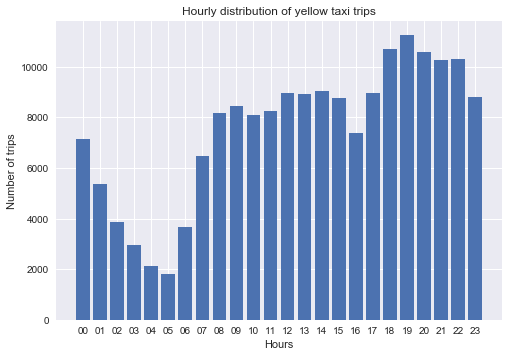

In [75]:
figure1()

We can see the number of trips rises to peak during 18:00-22:00, but goes down to the bottom at around 2:00-6:00

Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.


In [76]:
def figure2():
    import scipy.stats as st
    query1 = '''
    select 
    t_0.month as month,
    sum(t_0.total_trips) as total_trips,
    sum(t_0.distance) as distance

    from 

    (select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    yellow_taxi

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)

    union 

    select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    Uber

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)
    )t_0
    
    group by 
    t_0.month
    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['month','total_trips','distance'])
    df['avg_distance'] = df['distance']/df['total_trips']
    #compute the 90% CI 
    low_CI_bound, high_CI_bound = st.t.interval(0.90, len(df['avg_distance']) - 1,
                                            loc= df['avg_distance'].mean(),
                                            scale= st.sem(df['avg_distance']))
    plt.bar(df['month'],df['avg_distance'])
    plt.plot(df['month'], [low_CI_bound]*12,'--',label = 'low_CI_bound',color = 'purple')
    plt.plot(df['month'], [high_CI_bound]*12,'--',label = 'high_CI_bound',color = 'blue')
    plt.plot(df['month'],[df['avg_distance'].mean()]*12,color = 'r',label = 'Mean Value')

    
    plt.title('Monthly distribution of average distance for hired taxi')
    plt.xlabel('Month')
    plt.ylabel('Average Distance')
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    plt.show()

[sqlalchemy] 
    select 
    t_0.month as month,
    sum(t_0.total_trips) as total_trips,
    sum(t_0.distance) as distance

    from 

    (select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    yellow_taxi

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)

    union 

    select 
    strftime ('%m',pickup_time) as month,
    count(*) as	total_trips,
    sum(distance) as distance

    from 
    Uber

    where 
    pickup_time between '2009-01-01' and '2015-06-30'

    group by 
    strftime ('%m',pickup_time)
    )t_0
    
    group by 
    t_0.month
    
[sqlalchemy] [raw sql] ()


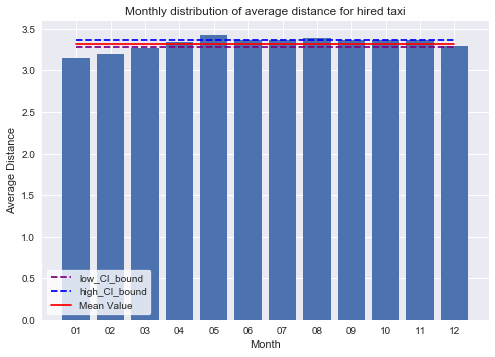

In [77]:
figure2()

The short width between low CI and high CI indicates the stability of distance distribution  

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.


In [78]:
## LGA: -73.890736,40.764350,-73.850310,40.786514
## JFK: -73.827581,40.620071,-73.746385,40.665530
## EWR: -74.193342,40.685069,-74.166541,40.695986

In [79]:
def figure3():
    query1 = '''
    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    Uber 
    '''
    airports = {'LGA':[-73.890736,40.764350,-73.850310,40.786514],
                'JFK':[-73.827581,40.620071,-73.746257,40.665530],
                'EWR':[-74.193342,40.685069,-74.166541,40.695986]
               }
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['day','dropoff_longitude','dropoff_latitude'])
    for airport in airports.keys():
        location = airports[airport]
        # make sure that Uber's pickup/drop off location is in a certain airport
        df_temp = df.loc[(df['dropoff_longitude']>=location[0])&(df['dropoff_longitude']<=location[2])
                         &(df['dropoff_latitude']>=location[1])&(df['dropoff_latitude']<=location[3])]
    
        df_temp = df_temp.groupby(['day']).size().reset_index().rename(columns = {0:'count'})
        
        plt.bar(df_temp['day'], df_temp['count'])
        x_ticks = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
        plt.xticks(np.arange(7),x_ticks)
        plt.title('Daily distribution of drop offs amount near {}'.format(airport))
        plt.xlabel('Day of the week')
        plt.ylabel('Number of drop offs')
        plt.show()

[sqlalchemy] 
    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    strftime ('%w',pickup_time) as day,
    dropoff_longitude,
    dropoff_latitude


    from 

    Uber 
    
[sqlalchemy] [raw sql] ()


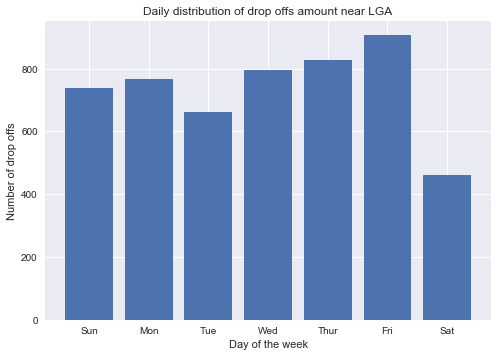

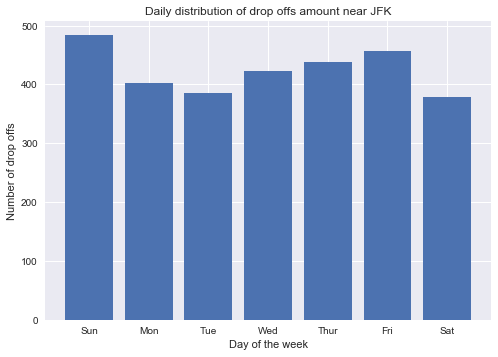

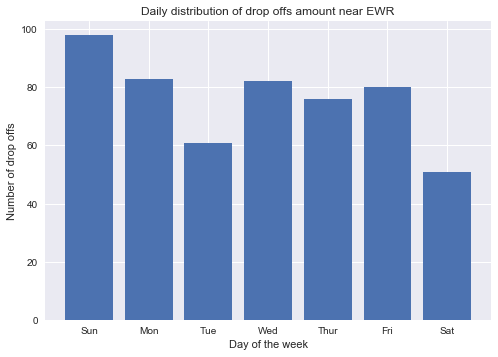

In [80]:
figure3()

Thus, the most popular day for drop offs in LGA, JFK and EWR is Friday, Sunday and Sunday respectively

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.


In [81]:
def createZoneTable(zone_factor,westlimit, southlimit, eastlimit, northlimit):
    # define a box area and split it into zone_factor*zone_factor parts
    zone_table = list()
    hor = np.linspace(start = westlimit, stop = eastlimit, num=zone_factor+1)
    ver = np.linspace(start = southlimit, stop = northlimit, num=zone_factor+1)
    for i in range(zone_factor*zone_factor):
        zone_number = "%02d" % i 
        bottomleft_co = [hor[i%zone_factor],ver[i//zone_factor]]
        bottomright_co = [hor[(i%zone_factor+1)],ver[i//zone_factor]]
        upperleft_co = [hor[i%zone_factor],ver[i//zone_factor+1]]
        upperright_co = [hor[i%zone_factor+1],ver[i//zone_factor+1]]
        zone_table.append((zone_number,[bottomleft_co,bottomright_co,upperright_co,upperleft_co,bottomleft_co]))
    return zone_table

In [82]:
def createGeoJsonObject(zone_table):
    # convert the coordinates into geojson object
    zone_data_dict = dict()
    zone_data_dict['type'] = 'FeatureCollection'
    zone_data_dict_features = list()
    zone_data_dict['features'] = zone_data_dict_features
    
    for index in range(len(zone_table)):
        coordinates_list = [zone_table[index][1]]
        zone_id = zone_table[index][0]        
        content = {
            'geometry': {"coordinates": coordinates_list,'type':'Polygon'},
            "properties":{'zone_id':zone_id},
            'type':'Feature'
        }
        zone_data_dict_features.append(content)
    
    return zone_data_dict

In [83]:
def get_zone(lon,lat,zone_table):
    # for each coordinate, get the cooresponding zone id
    for i in range(len(zone_table)):
        zone = None
        item = zone_table[i]
        hormin = item[1][0][0]
        vermin = item[1][0][1]
        hormax = item[1][2][0]
        vermax = item[1][2][1]
        if np.logical_and(lon<=hormax,lon>=hormin) & np.logical_and(lat<=vermax,lat>=vermin):
            zone = item[0]
            break
    return zone

In [84]:
def figure4():
    query1 = '''
    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude

    from 

    Uber 
    '''
 
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])

    # drawing pick up distribution 
    zonetable = createZoneTable(20,df['pickup_longitude'].min(), df['pickup_latitude'].min(), 
                            df['pickup_longitude'].max(), df['pickup_latitude'].max())
    df['pickup_zone'] = df.apply(lambda x: get_zone(x['pickup_longitude'],x['pickup_latitude'],zonetable),axis=1)
    
    pickup_cnt = df.groupby(['pickup_zone']).size().to_frame().rename(columns = {0:'pickup_count'}).reset_index()
    
    import folium
    #center the map at Times Square
    m = folium.Map(location = [40.7589,-73.9851],zoom_start=12,titles = 'Heatmap for pickups')
    m.choropleth(geo_data = createGeoJsonObject(zonetable) , data = pickup_cnt, 
                 columns=['pickup_zone', 'pickup_count'],key_on="properties.zone_id",
                 fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
                 legend_name='Distribution of pickups')
    folium.LayerControl().add_to(m)
    return m
    
    

In [85]:
figure4()

[sqlalchemy] 
    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude


    from 

    yellow_taxi

    union 

    select 
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude

    from 

    Uber 
    
[sqlalchemy] [raw sql] ()


/Users/yuanshuqing/.local/lib/python3.6/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.


In [86]:
def estimate_gaussian(dataset):
    # define a function to sort out outliers
    mu = np.mean(dataset) # moyenne cf mu
    sigma = np.std(dataset) # standard deviation
    limit = sigma * 1.5

    min_threshold = mu - limit
    max_threshold = mu + limit

    return mu, sigma, min_threshold, max_threshold

In [99]:
def figure5():
    query1 = '''
    select 
    tip,
    distance

    from 

    yellow_taxi
    '''
    
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['tip','distance'])
    
    #In order to compute ratio, make sure that the distance is not zero
    df['distance'] = df['distance'].apply(lambda x: x+1e-5 if x==0 else x)
    df['ratio'] = df['tip']/df['distance']
    
    mu, sigma, min_threshold, max_threshold = estimate_gaussian(df['ratio'].values)

    condition1 = (df['ratio'] < min_threshold)
    condition2 = (df['ratio'] > max_threshold)
    
    outliers1 = np.extract(condition1, df['ratio'])
    outliers2 = np.extract(condition2, df['ratio'])

    outliers = np.concatenate((outliers1, outliers2), axis=0)
    df_red = df[df['ratio'].isin(outliers)]
    df = df[~df['ratio'].isin(outliers)]
    
    #assign different colors to normal points and outliers 
    plt.scatter(df['distance'],df['tip'],label = 'normal',zorder = 0)
    plt.scatter(df_red['distance'],df_red['tip'], c ='brown',label = 'outliers',zorder = 1)
    #add a fitted line 
    plt.plot(df['distance'], np.poly1d(np.polyfit(df['distance'], df['tip'], 1))(df['distance']),color = 'purple',label = 'fitted_values')
    
    plt.title('Relationship between tips and distance')
    plt.xlabel('Distance')
    plt.ylabel('Tips')
    plt.legend()
    plt.show()
    

[sqlalchemy] 
    select 
    tip,
    distance

    from 

    yellow_taxi
    
[sqlalchemy] [raw sql] ()


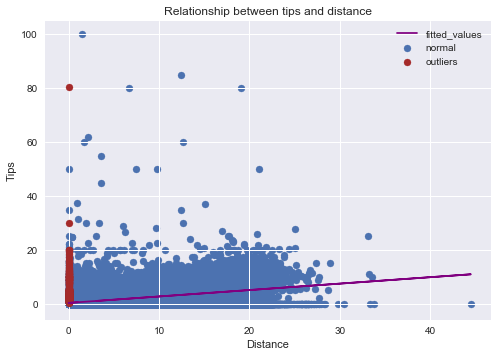

In [100]:
figure5()

As a whole, the tips are positively related to the distance. 

Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [101]:
def figure6():
    query1 = '''
    select 
    t_1.date as date,
    t_1.tip as tip,
    t_2.precipitation as precipitation

    from 

    (select

    strftime ('%Y-%m-%d',pickup_time) as date,
    avg(tip) as tip 

    from 
    yellow_taxi

    group by 
    strftime ('%Y-%m-%d',pickup_time) 
    )t_1

    left join 

    (select 
    strftime ('%Y-%m-%d',date) as date,
    precipitation    

    from 
    weather_daily
    )t_2

    on 
    t_1.date = t_2.date
    '''
    #similar logic as figure 5
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['hourly_date','tip','precipitation'])

    df['ratio'] = df['tip']/(df['precipitation'].apply(lambda x: x+0.0000001 if x==0 else x))
    
    mu, sigma, min_threshold, max_threshold = estimate_gaussian(df['ratio'].values)

    condition1 = (df['ratio'] < min_threshold)
    condition2 = (df['ratio'] > max_threshold)
    
    outliers1 = np.extract(condition1, df['ratio'])
    outliers2 = np.extract(condition2, df['ratio'])

    outliers = np.concatenate((outliers1, outliers2), axis=0)
    df_red = df[df['ratio'].isin(outliers)]
    df = df[~df['ratio'].isin(outliers)]
    
    plt.scatter(df['precipitation'],df['tip'],label = 'normal',zorder = 0)
    plt.scatter(df_red['precipitation'],df_red['tip'], c ='brown',label = 'outliers',zorder = 1)
    
    plt.title('Relationship between tips and precipitation')
    plt.xlabel('Precipitation')
    plt.ylabel('Tips')
    plt.legend()
    plt.show()
    

[sqlalchemy] 
    select 
    t_1.date as date,
    t_1.tip as tip,
    t_2.precipitation as precipitation

    from 

    (select

    strftime ('%Y-%m-%d',pickup_time) as date,
    avg(tip) as tip 

    from 
    yellow_taxi

    group by 
    strftime ('%Y-%m-%d',pickup_time) 
    )t_1

    left join 

    (select 
    strftime ('%Y-%m-%d',date) as date,
    precipitation    

    from 
    weather_daily
    )t_2

    on 
    t_1.date = t_2.date
    
[sqlalchemy] [raw sql] ()


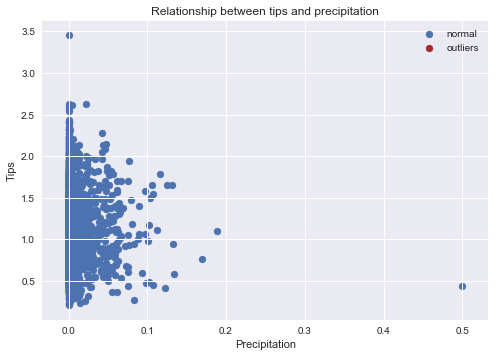

In [102]:
figure6()

No particular trend has been detected

Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.


<li> 1.What is the trend of yellow taxi' tips during one year?

In [91]:
def figure7_1():
    query1 = '''
    select 
    strftime ('%m',pickup_time) as date,
    avg(tip) as tip

    from 

    yellow_taxi

    group by 

    strftime ('%m',pickup_time) 
    '''
    
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['month','tip'])

    plt.plot(df['month'],df['tip'])
     
    plt.title('Trend of tips')
    plt.xlabel('Month')
    plt.ylabel('Tips')
    plt.show()
    

[sqlalchemy] 
    select 
    strftime ('%m',pickup_time) as date,
    avg(tip) as tip

    from 

    yellow_taxi

    group by 

    strftime ('%m',pickup_time) 
    
[sqlalchemy] [raw sql] ()


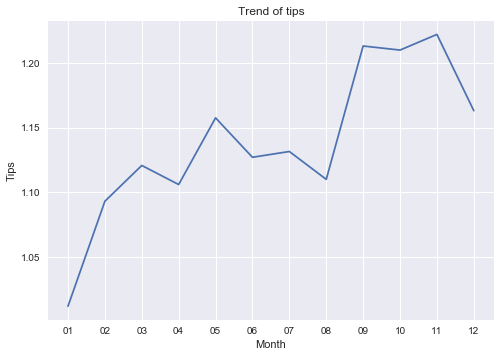

In [92]:
figure7_1()

The tips increases as the weather gets colder, especially in winter.

<li> 2.What is the relationship between precpitation and charge for all hired trips? (widget on year)

In [103]:
def figure7_2(selected_year = 2009):
    query1 = '''
    select 
    t_1.year as year,
    t_1.date as date,
    t_1.precipitation as precipitation,
    t_2.avg_charge as avg_charge


    from 


    (select 
    strftime ('%Y',date) as year,
    strftime ('%Y-%m-%d',date) as date,
    precipitation 

    from 

    weather_daily

    where date between '2009-01-01' and '2015-12-31'
    )t_1

    left join 

    (select

    strftime ('%Y',pickup_time) as year,
    strftime ('%Y-%m-%d',pickup_time) as date,
    avg(charge) as avg_charge 

    from 

    yellow_taxi

    where pickup_time between '2009-01-01' and '2015-12-31'

    group by 
    strftime ('%Y-%m-%d',pickup_time) 

    union 

    select

    strftime ('%Y',pickup_time) as year,
    strftime ('%Y-%m-%d',pickup_time)  as date,
    avg(charge) as avg_charge 

    from 

    Uber

    where pickup_time between '2009-01-01' and '2015-12-31'

    group by 
    strftime ('%Y-%m-%d',pickup_time) 
    )t_2

    on t_1.date = t_2.date
    and t_1.year = t_2.year

    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['year','date','precipitation','avg_charge'])
    df.year = df.year.astype(int)
    df = df[df.year == selected_year]
    fig,ax = plt.subplots()
    df.plot(kind="scatter", x="precipitation", y="avg_charge", label="average charge",figsize=(10,7),ax=ax)
    plt.legend()
    plt.show();
    

In [104]:
interact(figure7_2,
            selected_year = [2009,2010,2011,2012,2013,2014,2015])

interactive(children=(Dropdown(description='selected_year', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015)…

<function __main__.figure7_2(selected_year=2009)>

No significant relationship has been found, the distribution seems to have no pattern

<li> 3.What is the relationship between tip amount and hours? (wdiget on day)

In [105]:
def figure7_3(selected_weekday = 'Monday'):
    query1 = '''
    select 
    strftime ('%H',pickup_time) as hour,
    strftime ('%w',pickup_time) as day,
    tip


    from 

    yellow_taxi
    '''
    df = pd.DataFrame(data = engine.execute(query1).fetchall(),columns = ['hour','day','tip'])
    df = df.astype({'hour':int,'day':int})
    df = df.groupby(['day','hour']).mean()
    df.index.set_levels([[u'Sunday', u'Monday', u'Tuesday', u'Wednesday',u'Thursday',u'Friday',u'Saturday'],np.arange(0,24)], inplace=True)
    df = df.loc[selected_weekday].reset_index()
    plt.bar(df['hour'],df['tip']);

    

In [106]:
interact(figure7_3,
            selected_weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

interactive(children=(Dropdown(description='selected_weekday', options=('Monday', 'Tuesday', 'Wednesday', 'Thu…

<function __main__.figure7_3(selected_weekday='Monday')>

The tip is higher when it is early morning (around 5 o'clock)

## Unit Test

In [102]:
import pytest
import ipytest

ipytest.autoconfig(raise_on_error=True)

### test create_weather_csv(filename)

In [103]:
create_weather_csv('2072_weather.csv')

In [104]:
def test_create_weather_csv():
    df_1 = pd.read_csv('2072_weather_days.csv')
    df_2 = pd.read_csv('2072_weather_hours.csv')
    assert ('DailyPrecipitation' in df_1.columns) == True
    assert ('DailyWindSpeed' in df_1.columns) == True 
    assert ('HourlyPrecipitation' in df_2.columns) == True
    assert ('HourlyWindSpeed' in df_2.columns) == True
    
    

In [105]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_create_weather_csv")
### END TESTS    

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 5 items / 2 deselected / 3 selected

tmp62a03o20.py::test_create_weather_csv PASSED                                               [ 33%]
tmp62a03o20.py::test_create_weather_csv_1 PASSED                                             [ 66%]
tmp62a03o20.py::test_create_weather_csv_2 PASSED                                             [100%]

================================= 3 passed, 2 deselected in 0.05s =================================


<ExitCode.OK: 0>

### test get_distance()

In [67]:
@pytest.mark.parametrize(
    "x1,x2,x3,x4,result",
    (
        (1,2,3,4,314),
        (0,0,1,1,157),
    )
)

def test_get_distance(x1,x2,x3,x4,result):
    assert round(get_distance(x1,x2,x3,x4)) == result
    

In [69]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_get_distance")
### END TESTS    

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 2 items

tmpzxbf4zsr.py::test_get_distance[1-2-3-4-314] PASSED                                        [ 50%]
tmpzxbf4zsr.py::test_get_distance[0-0-1-1-157] PASSED                                        [100%]

======================================== 2 passed in 0.02s ========================================


<ExitCode.OK: 0>

### test add_distance()

In [120]:
uber = pd.read_csv('uber_rides_sample.csv')

In [121]:
def test_add_distance():
    add_distance(uber)
    assert ('distance' in uber.columns) == True
    

In [122]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_add_distance")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 6 items / 5 deselected / 1 selected

tmppfr9bbra.py::test_add_distance PASSED                                                     [100%]

================================= 1 passed, 5 deselected in 0.43s =================================


<ExitCode.OK: 0>

### test get_csv_links()

In [125]:
def test_get_csv_links():
    assert len(get_csv_links()) == 84
    

In [126]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_get_csv_links")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 7 items / 6 deselected / 1 selected

tmpm6lsf50c.py::test_get_csv_links PASSED                                                    [100%]

================================= 1 passed, 6 deselected in 0.13s =================================


<ExitCode.OK: 0>

### test fix_longitude()

In [137]:
def test_fix_longitude():
    assert (fix_longitude(0)) is np.NaN

In [138]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_fix_longitude")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 8 items / 7 deselected / 1 selected

tmp09vvhu0e.py::test_fix_longitude PASSED                                                    [100%]

================================= 1 passed, 7 deselected in 0.01s =================================


<ExitCode.OK: 0>

### test fix_latitude()

In [139]:
def test_fix_latitude():
    assert (fix_latitude(0)) is np.NaN

In [140]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_fix_latitude")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 9 items / 8 deselected / 1 selected

tmpzwuomar0.py::test_fix_latitude PASSED                                                     [100%]

================================= 1 passed, 8 deselected in 0.01s =================================


<ExitCode.OK: 0>

### test fix_df()

In [147]:
test_df = pd.DataFrame([[1,1,2,3]], columns = ['pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'])

In [148]:
def test_fix_df():
    fix_df(test_df)
    assert len(test_df) == 0

In [149]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_fix_df")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 10 items / 9 deselected / 1 selected

tmp03532757.py::test_fix_df PASSED                                                           [100%]

================================= 1 passed, 9 deselected in 0.02s =================================


<ExitCode.OK: 0>

### readsql(filename)

In [155]:
def test_readsql():
    assert len(readsql('testsql.sql')) == 194376

In [156]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_readsql")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 11 items / 10 deselected / 1 selected

tmp3l8si2s_.py::test_readsql [sqlalchemy] SELECT 
*
FROM
yellow_taxi
[sqlalchemy] [cached since 98.97s ago] ()
PASSED                                                          [100%]

================================ 1 passed, 10 deselected in 0.77s =================================


<ExitCode.OK: 0>

### test createuber()

In [158]:
def test_createuber():
    uber = createuber()
    assert len(uber) == 194367


In [159]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_createuber")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 12 items / 11 deselected / 1 selected

tmp8hthx29d.py::test_createuber PASSED                                                       [100%]

================================ 1 passed, 11 deselected in 0.31s =================================


<ExitCode.OK: 0>

### test createtaxi()

In [170]:
def test_createtaxi():
    taxi = createtaxi()
    assert len(taxi) == 194376


In [171]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_createtaxi")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 13 items / 12 deselected / 1 selected

tmph5cjstlw.py::test_createtaxi PASSED                                                       [100%]

================================ 1 passed, 12 deselected in 1.17s =================================


<ExitCode.OK: 0>

### test createhourlyweather()

In [175]:
def test_createhourlyweather():
    weather_hourly= createhourlyweather()
    assert len(weather_hourly) == 60458

In [176]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_createhourlyweather")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 14 items / 13 deselected / 1 selected

tmp787p6kt1.py::test_createhourlyweather PASSED                                              [100%]

================================ 1 passed, 13 deselected in 0.12s =================================


<ExitCode.OK: 0>

### test createdailyweather()

In [178]:
def test_createdailyweather():
    weather_daily = createdailyweather()
    assert len(weather_daily) == 2556


In [179]:
### BEGIN TESTS
ipytest.run("-vv", "-k", "test_createdailyweather")
### END TESTS  

======================================= test session starts =======================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- D:\Anon\python.exe
cachedir: .pytest_cache
rootdir: d:\TFA_project\UberTaxisAnalysis
plugins: anyio-3.5.0
collecting ... collected 15 items / 14 deselected / 1 selected

tmpk4z8n04v.py::test_createdailyweather PASSED                                               [100%]

================================ 1 passed, 14 deselected in 0.03s =================================


<ExitCode.OK: 0>